## Heart signal information - Second method 


In this second method, the [wfdb library](https://wfdb.readthedocs.io/en/latest/) is used to display all the information related to the heart signal loaded from the database.

This library is able to process all the information contained in the ECG signal from the database. Useful information such as average and total heart beat in the signal, beat of the signal and complex QRS is obtained.

The necessary libraries are imported and a random number generator is created.

In [1]:
import pandas as pd
import numpy as np
import ast
import wfdb
from wfdb import processing
import matplotlib.pyplot as plt
import heartpy as hp
import ecg_plot
import os
import glob

import warnings
warnings.filterwarnings('ignore')

# Create random generator with its seed
rng = np.random.default_rng(123)

Function to display QRS peaks and heart rate of the signal

In [2]:
def peaks_hr(sig:np.ndarray, peak_inds:np.ndarray, fs:int, title:str):
    """Plot a signal with its peaks and heart rate

    Args:
        sig (numpy.ndarray): Signal read
        peak_inds (numpy.ndarray): Peaks of QRS detected
        fs (int): Frecuency Sampling
        title (str): Title of plot
    """
    
    # Calculate heart rate
    hrs = processing.hr.compute_hr(sig_len=sig.shape[0], qrs_inds=peak_inds, fs=fs)
        
    N = sig.shape[0]
    fig, ax_left = plt.subplots(figsize=(20,10))
    ax_right = ax_left.twinx()
    
    ax_left.plot(sig, color='#3979f0', label='Signal')
    ax_left.plot(peak_inds, sig[peak_inds], 'rx', marker='x', color='#8b0000', label='Peak', markersize=12)
    ax_right.plot(np.arange(N), hrs, label='Heart rate', color='m', linewidth=2)

    ax_left.set_title(title)

    ax_left.set_xlabel('Time (ms)')
    ax_left.set_ylabel('ECG (mV)', color='#3979f0')
    ax_right.set_ylabel('Heart rate (bpm)', color='m')

    # Make the y-axis label, ticks and tick labels match the line color.
    ax_left.tick_params('y', colors='#3979f0')
    ax_right.tick_params('y', colors='m')
    
    # Show plot
    plt.show()


Using the second method to load the database

In [3]:
# Setup data variables
db_path = '../data/physionet.org/files/ptb-xl/1.0.2/records'
sampling_rate = 100 # Sampling rate of the signal (100 or 500)
path = db_path + str(sampling_rate) + "/" # Complete path

# Check that the folder exists
try:
    folder_exists = os.path.exists(path)
    if not folder_exists: 
        raise FileNotFoundError()
except FileNotFoundError:
    print("Folder " + path + " does not exists!")

# Store all data paths
data = []
for f in glob.glob(path + '/**/*.dat', recursive=True):
    data.append(f.split(".dat")[0]) # Remove extension from path

Random database is selected

In [39]:
# Select random data file
data_path = data[rng.integers(low=0, high=len(data))]
print ("Selected: " + str(data_path.split("1.0.2/")[1]))

Selected: records100/19000/19437_lr


The loaded data are processed and their QRS peaks are displayed both in a raw form upon detection and in a corrected form.

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


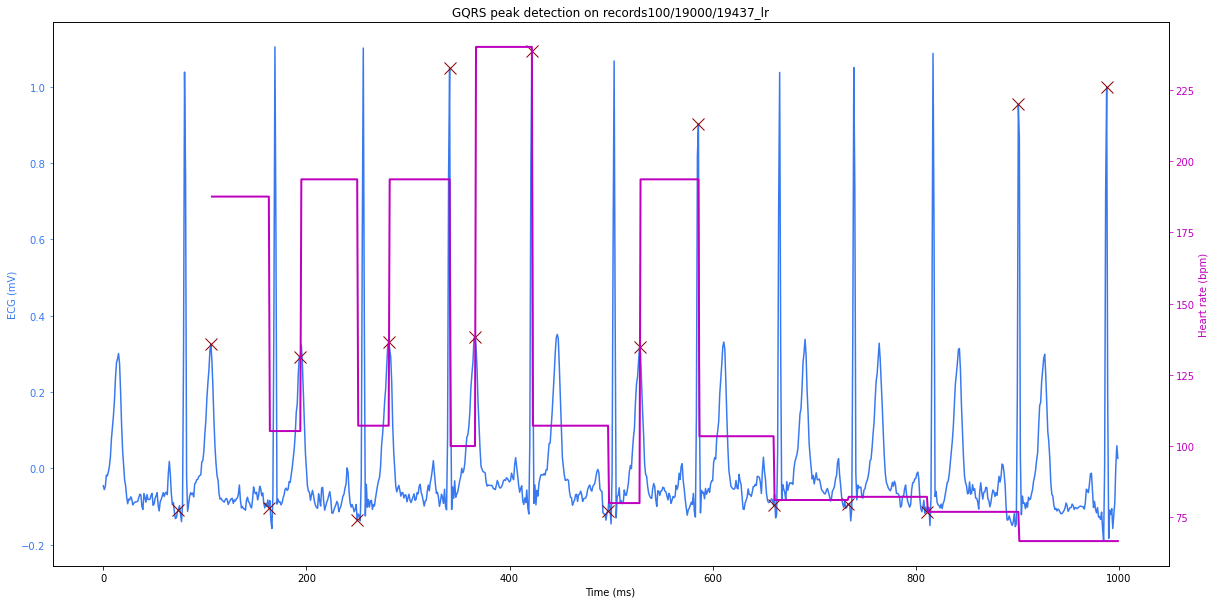

Detected GQRS peak indices: [74, 106, 163, 194, 250, 281, 341, 366, 422, 497, 528, 586, 660, 733, 811, 901, 988]
Corrected GQRS detected peak indices: [80, 80, 169, 169, 256, 256, 341, 341, 422, 503, 503, 586, 666, 739, 817, 901, 988]
Mean heart rate in BPM:  105.03282275711159
Corrected mean heart rate in BPM:  105.72687224669603


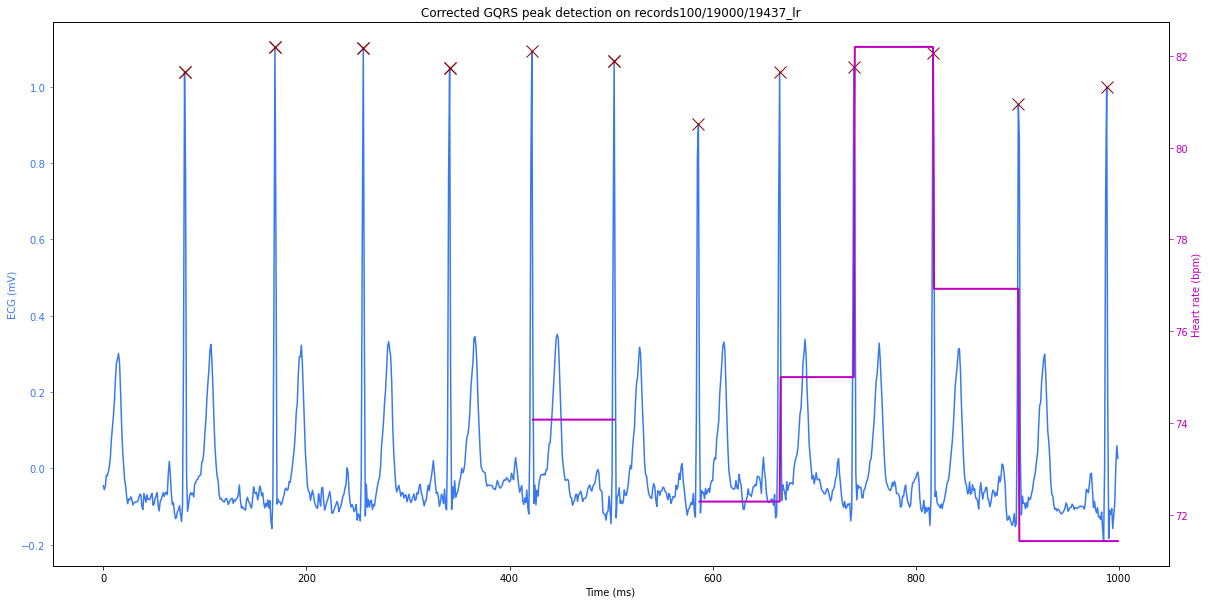

In [40]:
# Read a WFDB header file and return a Record or MultiRecord object with the record descriptors as attributes
header = wfdb.rdheader(data_path, pn_dir=None, rd_segments=False)

# Select one (first by default) channel from data file
channel = 0

# Load the WFDB record and the physical samples
record = wfdb.rdrecord(data_path, channels=[channel])

# Read a WFDB record, and return the physical signals and a few important descriptor fields.
sig, fields = wfdb.rdsamp(data_path, channels=[channel])

qrs_inds = processing.xqrs_detect(sig=sig[:,0], fs=fields['fs'])

# Plot results
peaks_hr(sig=record.p_signal, peak_inds=qrs_inds, fs=record.fs, title="GQRS peak detection on " + str(data_path.split("1.0.2/")[1]))
    
# Correct the peaks shifting them to local maxima
min_bpm = 20
max_bpm = 230

# Use the maximum possible bpm as the search radius
search_radius = int(record.fs * 60 / max_bpm)
corrected_peak_inds = processing.peaks.correct_peaks(record.p_signal[:,0], 
                                                     peak_inds=qrs_inds,
                                                     search_radius=search_radius, 
                                                     smooth_window_size=150)

# Compute R-R intervals from QRS indices by extracting the time differences
rr = processing.calc_rr(qrs_inds, fs=header.fs, qrs_units='samples', rr_units='samples')

# Compute mean heart rate in beats per minute, from a set of R-R intervals.
mean_hr = processing.calc_mean_hr(rr, fs=header.fs)

# Corrected R-R intervals
rr_corrected = processing.calc_rr(corrected_peak_inds, fs=header.fs, qrs_units='samples', rr_units='samples')

# Corrected mean heart rate in beats per minute
mean_hr_corrected = processing.calc_mean_hr(rr_corrected, fs=header.fs)

# Display results
print('Detected GQRS peak indices:', sorted(qrs_inds))
print('Corrected GQRS detected peak indices:', sorted(corrected_peak_inds))
print('Mean heart rate in BPM: ', str(mean_hr))
print('Corrected mean heart rate in BPM: ', str(mean_hr_corrected))

peaks_hr(sig=record.p_signal, 
         peak_inds=sorted(corrected_peak_inds), 
         fs=record.fs,
         title="Corrected GQRS peak detection on " + str(data_path.split("1.0.2/")[1]))